#### Akshay Santoshi - CS21BTECH11012
#### Nitya Bhamidipaty - CS21BTECH11041

### Assignment - 4 : GAN Synthetic Data Generation

In [2]:
# importing required libraies
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
import seaborn as sns

batch_size = 128
#setting random number generator
torch.manual_seed(111)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
def gradient_penalty(D, xr, xf):
    t = torch.rand(min(batch_size, xr.shape[0]), 1, device=xr.device)
    t = t.expand_as(xr)
    mid = t * xr + (1 - t) * xf
    mid.requires_grad_()
    pred = D(mid)
    grads = torch.autograd.grad(outputs=pred, inputs=mid,
                          grad_outputs=torch.ones_like(pred),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]


    gradients = grads.view(min(batch_size, xr.shape[0]), -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = ((torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12) - 1) ** 2).mean()
    return gradients_norm



def get_gen_loss(crit_fake_pred):
  gen_loss= -torch.mean(crit_fake_pred)
  return gen_loss


def get_crit_loss(crit_fake_pred, crit_real_pred, gradient_penalty, c_lambda):
  crit_loss= torch.mean(crit_fake_pred)- torch.mean(crit_real_pred)+ c_lambda* gradient_penalty
  return crit_loss

In [4]:
# Load Excel file
df = pd.read_excel('data.xlsx')
data_tensor = torch.tensor(df.values, dtype=torch.float32)

# Dummy labels (all zeros)
labels_tensor = torch.zeros(len(df), dtype=torch.float32)

# Create dataset
dataset = [(data_tensor[i], labels_tensor[i]) for i in range(len(df))]

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cov1                  1199 non-null   float64
 1   cov2                  1199 non-null   float64
 2   cov3                  1199 non-null   float64
 3   cov4                  1199 non-null   float64
 4   cov5                  1199 non-null   float64
 5   cov6                  1199 non-null   float64
 6   cov7                  1199 non-null   float64
 7   sal_pur_rat           1199 non-null   float64
 8   igst_itc_tot_itc_rat  1199 non-null   float64
 9   lib_igst_itc_rat      1199 non-null   float64
dtypes: float64(10)
memory usage: 93.8 KB


In [6]:
#Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 1)  # No sigmoid for WGAN
        )

    def forward(self, x):
        return self.model(x)




#Generator class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 10)  # Output layer
        )

    def forward(self, z):
        return self.model(z)


In [7]:

discriminator = Discriminator().to(device)
generator = Generator().to(device)

lr = 0.001
num_epochs = 500
n_critic = 3



#Optimizers to updated weights
optimizer_generator= optim.RMSprop(generator.parameters(), lr=5e-5)
optimizer_discriminator = optim.RMSprop(discriminator.parameters(), lr=5e-5)


for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        for i in range(n_critic):
            latent_space_samples = torch.randn((real_samples.shape[0], 10), device=device)
            generated_samples = generator(latent_space_samples)

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator_real = discriminator(real_samples)
            output_discriminator_generated = discriminator(generated_samples)
            gp= gradient_penalty(discriminator, real_samples, generated_samples )
            loss_discriminator =  get_crit_loss(output_discriminator_generated,output_discriminator_real,gp,c_lambda=5)

            loss_discriminator.backward()
            optimizer_discriminator.step()


        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 10), device=device)


        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = get_gen_loss(output_discriminator_generated)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n==0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Loss D.: -0.11770367622375488
Epoch: 0 Loss G.: 0.5834485292434692
Epoch: 10 Loss D.: -0.2513449490070343
Epoch: 10 Loss G.: -1.1387088298797607
Epoch: 20 Loss D.: 0.1892121434211731
Epoch: 20 Loss G.: -1.3587121963500977
Epoch: 30 Loss D.: 0.05247539281845093
Epoch: 30 Loss G.: -1.0032966136932373
Epoch: 40 Loss D.: 0.1094478964805603
Epoch: 40 Loss G.: -0.6732348203659058
Epoch: 50 Loss D.: 0.006988175213336945
Epoch: 50 Loss G.: -0.3457885980606079
Epoch: 60 Loss D.: -0.04260758310556412
Epoch: 60 Loss G.: 0.08133428543806076
Epoch: 70 Loss D.: -0.07267788797616959
Epoch: 70 Loss G.: 0.09597872942686081
Epoch: 80 Loss D.: 0.014400821179151535
Epoch: 80 Loss G.: -0.2163410186767578
Epoch: 90 Loss D.: -0.006929062306880951
Epoch: 90 Loss G.: 0.09428001940250397
Epoch: 100 Loss D.: -0.04423646628856659
Epoch: 100 Loss G.: 0.2415047287940979
Epoch: 110 Loss D.: -0.02763545885682106
Epoch: 110 Loss G.: 0.20989690721035004
Epoch: 120 Loss D.: -0.04211298003792763
Epoch: 120 Loss 

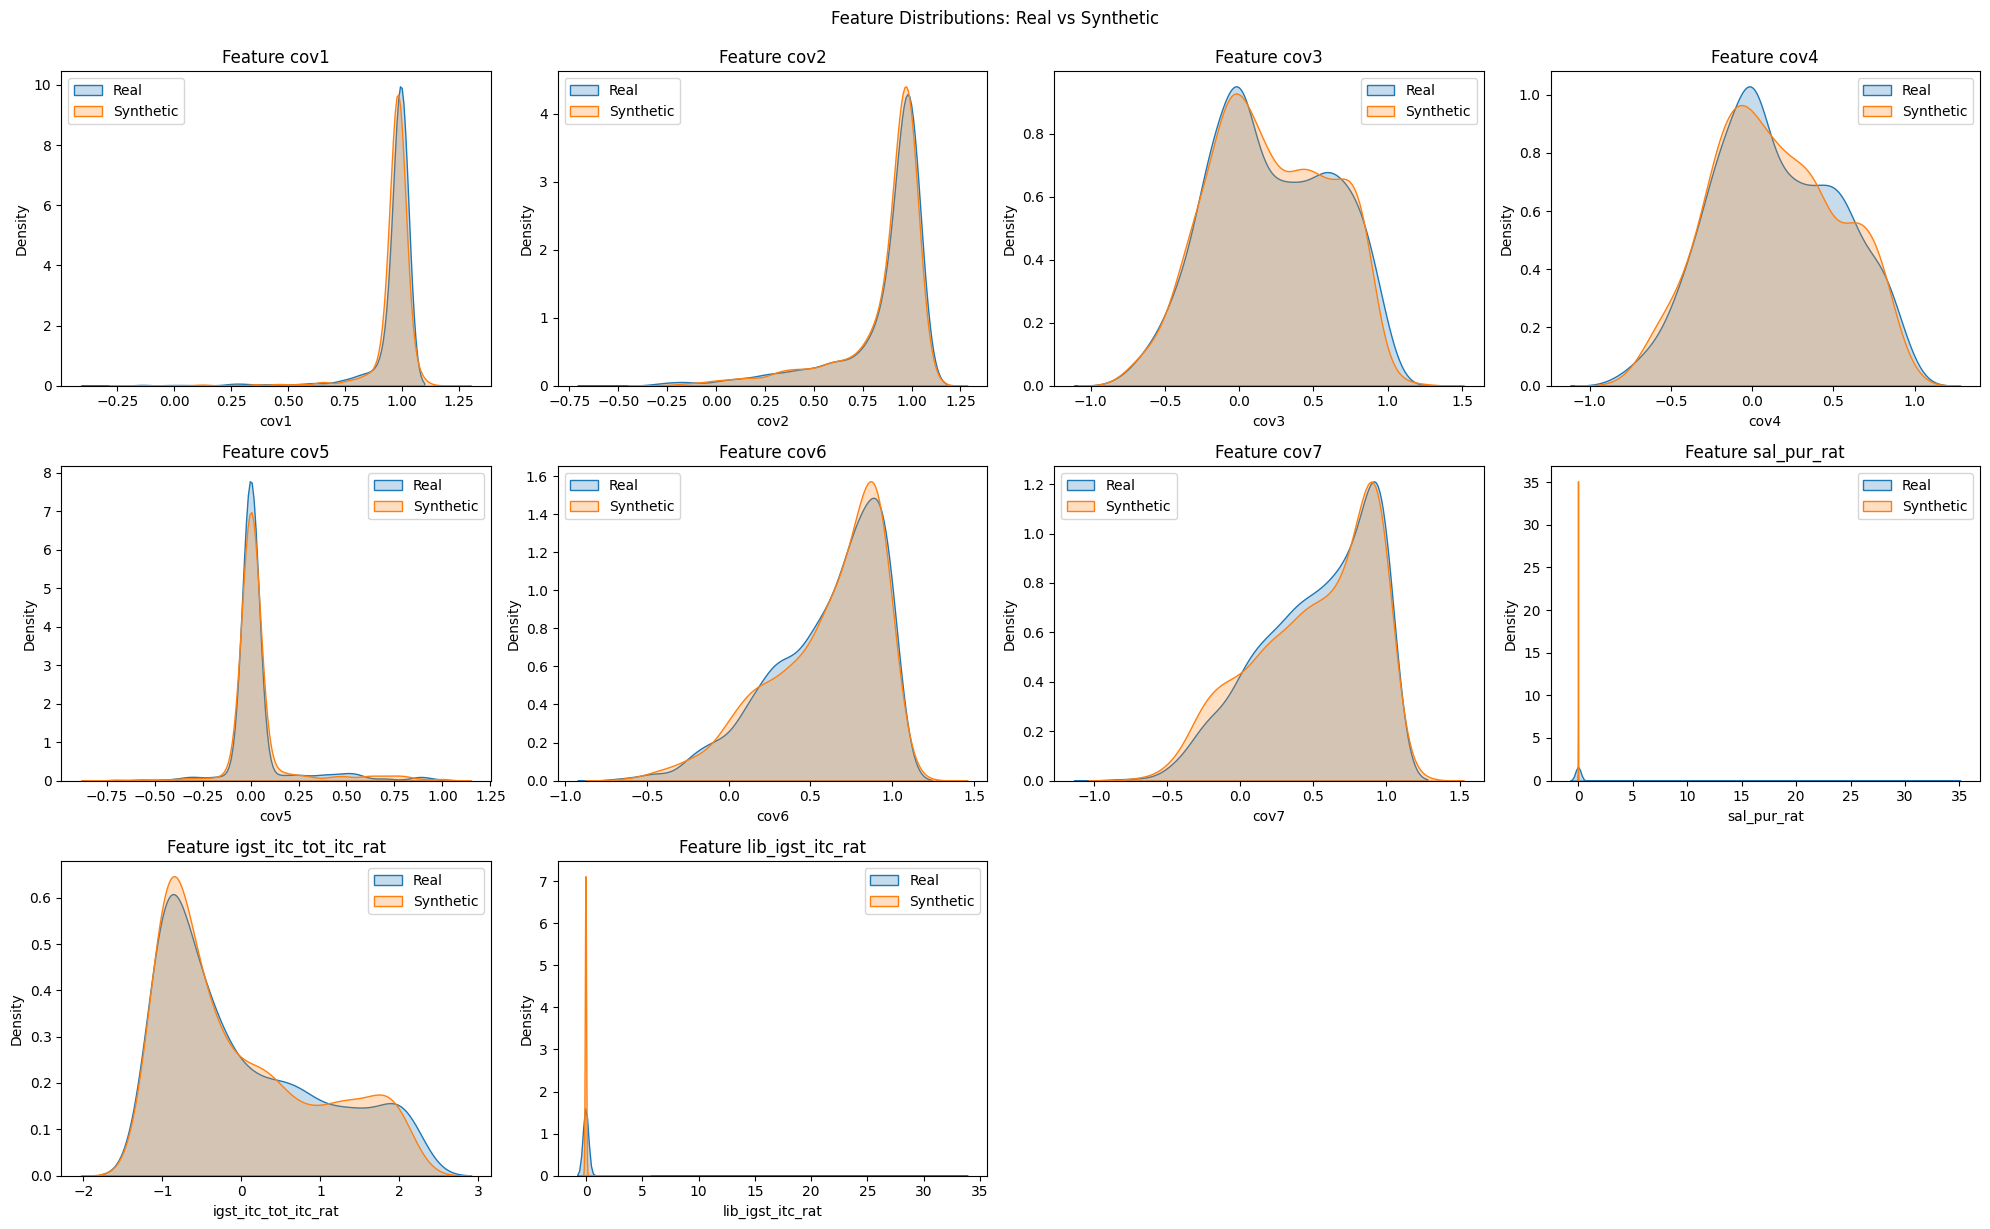

In [8]:
# Load real data from Excel
df_real = pd.read_excel("data.xlsx")

# Ensure it only contains the 10 features
assert df_real.shape[1] == 10, "Expected 10 features"

# Initialize and load the pre-trained Generator
# generator = Generator()
# generator.load_state_dict(torch.load("generator.pth", map_location=torch.device('cpu')))
generator.eval()

# Generate synthetic data
num_samples = df_real.shape[0]
latent_dim = 10
z = torch.randn(num_samples, latent_dim, device=device)
with torch.no_grad():
    synthetic_data = generator(z).cpu().numpy()
df_synth = pd.DataFrame(synthetic_data, columns=df_real.columns)

# 1. Plot distributions
plt.figure(figsize=(20, 12))
for i, col in enumerate(df_real.columns):
    plt.subplot(3, 4, i + 1)
    sns.kdeplot(df_real[col], label="Real", fill=True)
    sns.kdeplot(df_synth[col], label="Synthetic", fill=True)
    plt.title(f"Feature {col}")
    plt.legend()
plt.tight_layout()
plt.suptitle("Feature Distributions: Real vs Synthetic", y=1.02)
plt.show()

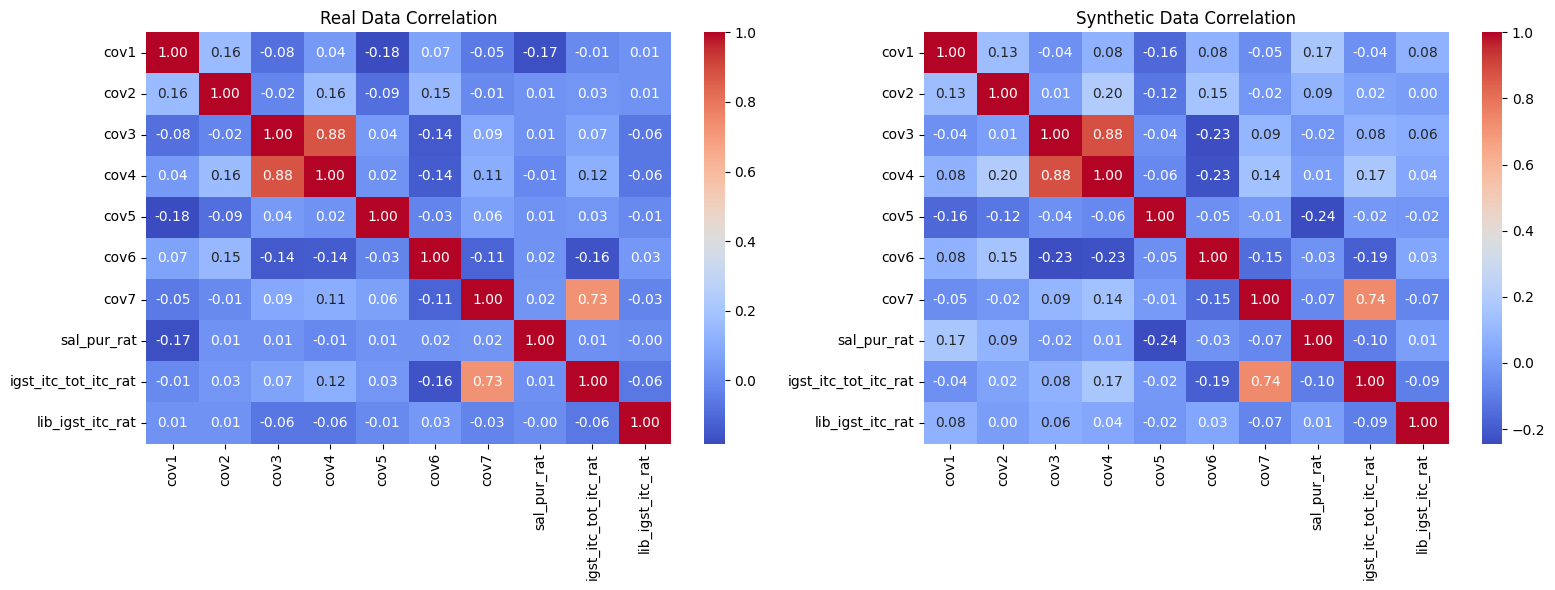

In [9]:
# 2. Compute Pearson correlation matrices
corr_real = df_real.corr(method="pearson")
corr_synth = df_synth.corr(method="pearson")

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(corr_real, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Real Data Correlation")

sns.heatmap(corr_synth, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Synthetic Data Correlation")

plt.tight_layout()
plt.show()

- The plots and the heatmaps of the real and synthetic data are similar.
- The model generates synthetic data close to real data.